## Make final depth to surface tables
This notebook generates the final depth to surface area tables for one reservoir at a time. You have to do one at a time, because each reservoir is different and you have to make a decision on each one about which images to use. You should have generated image profiles for each reservoir by now, so you can see the actual images from which the surface area is being calculated. This notebook is a little bit hard to use, so read the markdowns carefully.
 

In [1]:
#imports
import os
import xarray as xr
import numpy as np
import pandas as pd
import csv
#import glob    #This one lets you read all the csv files in a directory
import rasterio.crs
from tqdm.auto import tqdm #this one is a loading bar, it's cool to add loading bars to loops
from pandas import DataFrame
import geopandas as gpd
import matplotlib.gridspec as gs
import matplotlib.pyplot as plt
from matplotlib import pyplot
import datacube

import sys
sys.path.append('../../Scripts')
from dea_spatialtools import xr_rasterize
from dea_datahandling import wofs_fuser
from datacube.utils import geometry 
from datacube.utils.geometry import CRS
from datacube.utils import masking
from datacube.helpers import ga_pq_fuser, write_geotiff
#from digitalearthau.utils import wofs_fuser
#import DEAPlotting, DEADataHandling
import warnings
warnings.filterwarnings('ignore', module='datacube')
%load_ext autoreload
%autoreload 2

/env/lib/python3.6/site-packages/geopandas/_compat.py:88: UserWarning: The Shapely GEOS version (3.7.2-CAPI-1.11.0 ) is incompatible with the GEOS version PyGEOS was compiled with (3.9.0-CAPI-1.16.2). Conversions between both will be slow.
  shapely_geos_version, geos_capi_version_string


## Read csv and split into depth intervals
This is where you enter the location of the csv file of the initial depth to surface area table you made. The bad_rows variable can be used if you want to skip the lowest depths, for example if the first image is empty, eg surface area = 0, you will want to skip that, so put bad_rows = [0]. There is an argument in the code that says 'if the surface area for x depth is lower than x-1 depth, delete this image', because surface area going down with increasing depth obviously doesn't make sense. So if the second image is also 0, you don't have to enter it as a bad_row, because it's going to be deleted anyway. If you have an image at say, depth 6 that is going to be counted because it is a larger surface area than depth 5, however you notice that the image quality is bad, you can enter it as a bad_row so it doesn't get counted, so you might enter bad_rows = [0, 6]. If you have 0 or bad images for higher depths, don't worry because they are getting skipped anyway so you don't have to enter them. If you don't have any images that need to manually be skipped, hash this line out. The bad_row variable is just extra making sure you don't use bad images to calculate surface area. 

There is also an argument in this code block that says 'if there are more than 25 depth intervals, only use every 2m instead of every 1m'. This will give you better quality images because each image will be made of more passes. For big reservoirs like Blowering which varies by 70 meters, I think it's more accurate to have good quality images for every second meter and interpolate every other depth rather than try to make 70 images with only a few passes in each. But make a decision your self, if you have a reservoir that varies by 30m but you think the images are really good, change the code so it won't take every 2m and keep using every 1m.

There's also some annoying things about this box that I haven't really bothered to try and fix. Some of the gauge IDs are pure numbers, some of them have letters, making them strings. The code has to read the ID as a string, so if the gauge ID is a number, you will have to convert it to a string. If it's already a string and you try to convert it to a string, it will throw an error. I just hash the 'ID_str = ID_str.astype(str)' line in and out as needed. The other thing is that sometimes 2 bounding boxes will be called, which will make you get an error later (there might be 2 boxes because the spatial join matched one gauge to 2 different very close reservoirs). At the bottom there is a line that is 'box = box_row.geometry'. If you have 2 bounding boxes you need choose one like this: box = box_row.geometry[0] or box = box_row.geometry[1] and make sure you get the right one.  

In [2]:
csv = '00_Library/Coolmunda_416409A.csv'
bad_rows = [0,2] #these are the bad rows you want to drop, like if the first depth slice image is bad, put 0. must be in square brackets

#Get the ID of the gauge 
gauge_number_df = pd.read_csv(csv, nrows=1, escapechar='#')
column2 = list(gauge_number_df)[1]
gauge_number_df = gauge_number_df.rename(columns = {column2 : 'gauge_ID'})
ID_str = gauge_number_df.at[0, 'gauge_ID']
#ID_str = ID_str.astype(str)  #If this box returns an error it might be because the ID for that gauge is already a string. 
                             #If you get an error about strings you can hash this line out.
                            #If you get a Key Error, unhash this line
#Make depth duration curve
gauge_data = pd.read_csv(csv,
                error_bad_lines = False, skiprows=9, escapechar='#',
                         parse_dates=['Timestamp'], 
                         index_col=('Timestamp'),
                        date_parser=lambda x: pd.to_datetime(x.rsplit('+', 1)[0])) #Robbi wrote this line
gauge_data = gauge_data.dropna()
gauge_data = gauge_data.sort_values('Value')
gauge_data['rownumber'] = np.arange(len(gauge_data))
gauge_data['Exceedence'] = (1-(gauge_data.rownumber/len(gauge_data)))*100
gauge_data = gauge_data.drop(columns=['Interpolation Type', 'Quality Code'])

#Get the depth range and intervals
depth_integers = gauge_data.astype(np.int64)
max_depth = depth_integers.Value.max()
min_depth = depth_integers.Value.min()
integer_array = depth_integers.Value.unique()
integer_list = integer_array.tolist()

#Take every 2m of depth if the reservoir is large 
if len(integer_list) > 25:
    integer_list2 = integer_list[::2]
    print('This reservoir will take every 2m instead of every 1m, because it is quite large.')
else:
        integer_list2 = integer_list
        print('This reservoir will take every 1m of depth')
        
print('Number of depth intervals = ', len(integer_list2)) 

#Get the bounding box for the satellite query
bb_gdf = gpd.read_file('00_Lib_bound/00_Lib_bound.shp')
bb_gdf = bb_gdf.set_index(['gauge_ID'])
row_n = bb_gdf.index.get_loc(ID_str)
box_row = bb_gdf.loc[ID_str]
box = box_row.geometry#[0]  #If you are getting an error in the next box it might be because you are calling 2 bounding boxes
                            #use [0] or [1] to just get one bounding box if you are getting an error about polygons

print('Gauge ID = ', ID_str)
print('Depth intervals = ', len(integer_list2))
print('Polygon extent = ', box)

This reservoir will take every 1m of depth
Number of depth intervals =  11
Gauge ID =  416409A
Depth intervals =  11
Polygon extent =  POLYGON ((151.245256836103 -28.40090251183211, 151.2744440861379 -28.46863912567084, 151.2330994820684 -28.48645423670427, 151.2039122320336 -28.41871762286554, 151.245256836103 -28.40090251183211))


## Load satellite data and make depth to surface area table
If you have changed 'if len(integer_list) > 25:' to something other than 25, you need to change it in this box too.

There is an option to plot images here, but I have them hashed out because I usually don't want to see the images again. 

In [4]:
geom = geometry.Geometry(geom=box, crs=bb_gdf.crs)
query = {'time': ('01-01-1988', '23-02-2021')}
query.update({'geopolygon': geom})

dc = datacube.Datacube(app='dc-WOfS')

wofs_albers= dc.load(product = 'wofs_albers', dask_chunks = {}, group_by='solar_day', fuse_func = wofs_fuser, **query)
poly_mask = xr_rasterize(bb_gdf.geometry, wofs_albers)
wofs_albers = wofs_albers.where(poly_mask, other=wofs_albers.water.nodata) #put other or all the data turns into 0

gauge_data_xr = gauge_data.to_xarray() #convert gauge data to xarray
merged_data = gauge_data_xr.interp(Timestamp=wofs_albers.time) #use xarrays .interp() function to merge

surface_area_list = []
number_of_images_list = []
images_post_masking = []
for i in tqdm(integer_list2, total=len(integer_list2)):
    #If there are more than 25 meters in depth intervals, take every 2m depth
    if len(integer_list) > 25:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+2), drop=True)
    else:
        specified_level = merged_data.where((merged_data.Value > i) & 
                                    (merged_data.Value < i+1), drop=True)
    
    date_list = specified_level.time.values
    number_of_images = len(date_list)
    number_of_images_list.append(number_of_images)
    specified_passes = wofs_albers.sel(time=date_list).compute() #This .compute() Xarray function loads actual images
    
    #cloudmask (Claire Krause wrote this for me)
    cc = masking.make_mask(specified_passes.water, cloud=True)
    ncloud_pixels = cc.sum(dim=['x', 'y'])
    # Calculate the total number of pixels per timestep
    npixels_per_slice = (specified_passes.water.shape[1] * 
                         specified_passes.water.shape[2])
    cloud_pixels_fraction = (ncloud_pixels / npixels_per_slice)
    clear_specified_passes = specified_passes.water.isel(
        time=cloud_pixels_fraction < 0.2)
    images_post_masking.append(len(clear_specified_passes.time))
    wet = masking.make_mask(clear_specified_passes, wet=True).sum(dim='time')
    dry = masking.make_mask(clear_specified_passes, dry=True).sum(dim='time')
    clear = wet + dry
    frequency = wet / clear
    frequency = frequency.fillna(0)  
    
    #Get area from the satellite data
    #get the frequency array
    frequency_array = frequency.values
    #Turn any pixel in the frequency array with a value greater than 0.2 into a pixel of value 1
    #if the pixel value is 0.2 or lower it gets value 0
    is_water = np.where((frequency_array > 0.2),1,0)
    #give the 'frequency' xarray back its new values of zero and one
    frequency.values = is_water
    #sum up the pixels
    number_water_pixels = frequency.sum(dim=['x', 'y'])
    #get the number
    number_water_pixels = number_water_pixels.values.tolist()
    #multiply by pixel size to get area in m2
    area_m2 = number_water_pixels*(25*25)
    
    surface_area_list.append(area_m2)
    
        #Plotting the image (keep these hashed out if you don't want to see images)
    #fig = plt.figure()
    #frequency.plot(figsize = (7,5))
    #name = ID_str, i
    #images = plt.savefig('images/'+str(name)+'.png')
    #plt.close(fig)

    
              
#create dataframe of depth to surface area 
depth_to_area_df = DataFrame(integer_list2, columns=['Depth'])
depth_to_area_df['Surface Area'] = surface_area_list
depth_to_area_df['Number of images before masking'] = number_of_images_list
depth_to_area_df['Number of images after masking'] = images_post_masking
depth_to_area_df['ID'] = ID_str
depth_to_area_df

  0%|          | 0/11 [00:00<?, ?it/s]

,Depth,Surface Area,Number of images before masking,Number of images after masking,ID
0,304,0,0,0,416409A
1,305,0,0,0,416409A
2,306,18750,4,3,416409A
3,307,3438750,31,23,416409A
4,308,4986875,29,25,416409A
5,309,6634375,54,41,416409A
6,310,8358125,89,70,416409A
7,311,10611250,142,107,416409A
8,312,12891875,136,110,416409A
9,313,15345000,114,82,416409A


## Interpolate
This is the part where images showing lower surface area as depth increases get thrown out and instead the code will give them a value by interpolation. This is also where the bad_rows get taken into account. If you hashed out the bad_rows line in the first box, you will have to hash out the line here that uses that variable. 

In [5]:
obs_list = []
for i, obs in depth_to_area_df.iterrows():
    if i == 0: #We always put the first point in, even if it's bad (will fix later)
        obs_list.append(obs)
        continue
    if obs["Surface Area"] > obs_list[-1]["Surface Area"]: # if the number is bigger than the number before it, keep.
        obs_list.append(obs)

obs_df = pd.DataFrame(obs_list)
obs_df2 = obs_df

#drop the first real images that are bad
obs_df2 = obs_df.drop(index=bad_rows) #Delete rows made from bad images

obs_df3 = obs_df2.set_index("Depth")
min_ = obs_df3.index.min()
max_ = obs_df3.index.max()
obs_df4 = obs_df3.reindex(range(min_, max_+1))
obs_df4['Surface Area'] = obs_df4['Surface Area'].interpolate()
obs_df4['Depth'] = obs_df4.index
obs_df4['ID'] = obs_df3.at[min_, 'ID']
obs_df4 = obs_df4[['ID', 'Depth', 'Surface Area', 'Number of images after masking']]
obs_df4 = obs_df4.set_index("ID")
obs_df4

,Depth,Surface Area,Number of images after masking
ID,,,
416409A,307,3438750,23
416409A,308,4986875,25
416409A,309,6634375,41
416409A,310,8358125,70
416409A,311,10611250,107
416409A,312,12891875,110
416409A,313,15345000,82
416409A,314,16035625,22


## Extrapolate higher depths
The Interpolate function won't get the highest or lowest depths, as it can only get the inbetween depths. To get the lowers and higher depths I have used a simple polynomial (y = mx + b) to calculate what the curve might look like at the extremities of the depths. This might not be super super accurate, but it's probably close enough, and there won't be many days when the gauge reads these levels anyway, so error will be minimised for our purposes. The code block after this one will show you the curve with the extrapolated values. You can alter this code if you think the curve doesn't look quite right (eg if there is negative surface areas in the lower extrapolations). An image of this graph will be saved in the images folder.

In [6]:
y_orig = list(obs_df4['Surface Area'])
x_orig = list(obs_df4['Depth'])
ID = list(obs_df2.index)
ID = str(ID[0])

#Top point
x2 = x_orig[-2]
y2 = y_orig[-2]

#Second top point
x1 = x_orig[-1]
y1 = y_orig[-1]
m = (y2 - y1)/(x2 - x1)
b = y1-(m*x1)

#Get an extra 5m at the top
x_list = [x1, x1+1, x1+2, x1+3, x1+4, x1+5]


#Use the first degree polynomial to find y (surface area)
y_list = []    
for i in x_list:
    y = (m*i)+b # y = mx + b
    y_list.append(y)    

## Extrapolate lower depths

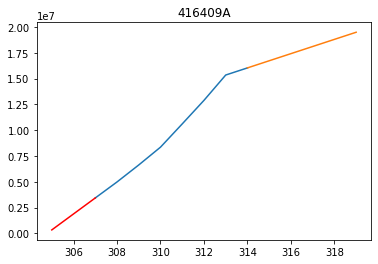

In [7]:
#Lowest point
x1 = x_orig[0]
y1 = y_orig[0]

#Second lowest point
x2 = x_orig[1]
y2 = y_orig[1]

m = (y2 - y1)/(x2 - x1)
b = y1-(m*x1)

#Get an extra 5m at the bottom
x_list2 = [x1, x1-1, x1-2]#, x1-3, x1-4, x1-5]


#Use the first degree polynomial to find y (surface area)
y_list2 = []    
for i in x_list2:
    y = (m*i)+b # y = mx + b
    y_list2.append(y)
    
plt.title(ID_str)
plt.plot(x_orig, y_orig)
plt.plot(x_list, y_list)
plt.plot(x_list2, y_list2, color='red')
plt.savefig('images/'+str(ID_str)+'.png')
plt.show()

## Add higher and lower depths onto the original dataframe
This code block makes your final depth to surface area table, which you can save out as a csv file. The 'Number of images after masking' column tells you how many images were stacked to calculate the final surface area. Anything with 10 or more images, I would consider quite accurate. If there's only 1 or 2 images, it could still be accurate depending on the pass, but you should check the image and make a decision. NaN values mean there were no images used in the calculation of that surface area, and the value was derived from either interpolation or extrapolation with the polynomial. 

In [8]:
#Higher depths
high_data = x_list, y_list
df_high = pd.DataFrame(data=high_data)
df_high = df_high.transpose()
df_high2 = df_high.rename(columns={0:'Depth', 1:'Surface_Area'})
depth_exp_high = df_high2.Depth.explode()
surface_exp_high = df_high2.Surface_Area.explode()
surface_exp_high = surface_exp_high.to_frame()
depth_exp_high = depth_exp_high.to_frame()
depth_exp_high['Surface Area'] = surface_exp_high
depth_exp_high['ID'] = ID_str
depth_exp_high = depth_exp_high.set_index("ID")

#Lower depths
low_data = x_list2, y_list2
df_low = pd.DataFrame(data=low_data)
df_low = df_low.transpose()
df_low2 = df_low.rename(columns={0:'Depth', 1:'Surface_Area'})
depth_exp_low = df_low2.Depth.explode()
surface_exp_low = df_low2.Surface_Area.explode()
surface_exp_low = surface_exp_low.to_frame()
depth_exp_low = depth_exp_low.to_frame()
depth_exp_low['Surface Area'] = surface_exp_low
depth_exp_low['ID'] = ID_str
depth_exp_low = depth_exp_low.set_index("ID")

#Add to Interpolated df
full_df = obs_df4.append(depth_exp_low)
full_df2 = full_df.append(depth_exp_high)
full_df2 = full_df2.sort_values(by=['Depth'])
full_df2

,Depth,Surface Area,Number of images after masking
ID,,,
416409A,305.0,342500.0,NaN
416409A,306.0,1890625.0,NaN
416409A,307.0,3438750.0,23.0
416409A,307.0,3438750.0,NaN
416409A,308.0,4986875.0,25.0
416409A,309.0,6634375.0,41.0
416409A,310.0,8358125.0,70.0
416409A,311.0,10611250.0,107.0
416409A,312.0,12891875.0,110.0


## Save the final table as a csv
The file will save onto the Sandbox and then you can download it onto your local machine. 

In [ ]:
full_df2.to_csv('corrected_dataframes/'+ID_str +'-corrected'+'.csv')